### Import libraries

In [1]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Linear algebra psuedo inverse
from scipy.linalg import pinv

In [3]:
# Learning algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_samples

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection # Randomized Projections
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture # Expectation Maximization

### Load Data

In [4]:
spambase_df = pd.read_csv('./data/spambase.data', header=None, error_bad_lines=False)

# Full Data
X = spambase_df.iloc[:, :-1].values
y = spambase_df.iloc[:, -1].values

# Split data into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=42)

### Plotting Functions

In [5]:
def plot_variance(var_exp, cum_var_exp, title=None, save_as=None):
    plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [6]:
def plot_elbow_distortions(max_clusters, X, title=None, save_as=None):
    distortions = []
    for i in range(1, max_clusters+1):
        km = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300, 
                    random_state=42)
        km.fit(X)
        distortions.append(km.inertia_)
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [7]:
def plot_elbow_bic(max_components, X, title=None, save_as=None):
    bic = []
    for i in range(1, max_components+1):
        gmm = GaussianMixture(n_components=i, 
                              covariance_type='full',
                              reg_covar=1e-06, 
                              max_iter=100, 
                              n_init=1, 
                              init_params='kmeans',
                              random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    plt.plot(range(1, max_components+1), bic, marker='s')
    plt.xlabel('Number of Components')
    plt.ylabel('Bayesian Information Criterion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [8]:
def plot_kurtosis(max_components, kurtosis, title=None, save_as=None):
    plt.plot(range(1, max_components+1), kurtosis, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Kurtosis')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [9]:
def plot_recon_error(max_components, error, title=None, save_as=None):
    plt.plot(range(1, max_components+1), error, marker='D')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [10]:
def plot_auc_scores(max_components, auc, title=None, save_as=None):
    plt.plot(range(1, max_components+1), auc, marker='p')
    plt.xlabel('Number of Components')
    plt.ylabel('ROC AUC')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [11]:
def plot_silhouette(km, X, title=None, save_as=None):
    y_km = km.predict(X)
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="orange", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [12]:
def plot_kmeans(km, X, xlim=None, ylim=None, title=None, save_as=None):
    y_km = km.predict(X)
    colors = ('lightgreen', 'purple', 'blue', 'orange', 'cyan')
    markers = ('s', 'o', 'v', 'p', 'd')
    for i in range(0, km.n_clusters):
        plt.scatter(X[y_km == i, 0],
                    X[y_km == i, 1],
                    s=50, c=colors[i],
                    marker=markers[i], edgecolor='black',
                    label='cluster '+str(i+1))
    plt.scatter(km.cluster_centers_[:, 0],
                km.cluster_centers_[:, 1],
                s=250, marker='*',
                c='red', edgecolor='black',
                label='centroids')
    
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [13]:
def plot_gmm(gmm, X, index=1, xlim=None, ylim=None, title=None, save_as=None):
    import itertools
    from scipy import linalg
    import matplotlib as mpl
    
    splot = plt.subplot(1, 1, 1)
    y_gmm = gmm.predict(X)
    color_iter = itertools.cycle(['lightgreen', 'purple', 'blue', 'orange', 'cyan', 'olive'])
    marker_iter = itertools.cycle(['s', 'o', 'v', 'p', 'd', 'H'])
    means = gmm.means_
    covariances = gmm.covariances_
    for i, (mean, covar, color, marker) in enumerate(zip(
            means, covariances, color_iter, marker_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(y_gmm == i):
            continue
        plt.scatter(X[y_gmm == i, 0], X[y_gmm == i, 1], 
                    color=color, marker=marker, edgecolor='black')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [14]:
def plot_feature_importance(X, importances, indices, save_as=None):
    plt.title('Random Forest Feature Importance')
    plt.bar(range(X_train.shape[1]), 
            importances[indices],
            align='center')

    plt.xticks(range(X_train.shape[1]), 
               feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [15]:
def plot_discriminability(eigen_vals, ylim=None, save_as=None):
    tot = sum(eigen_vals.real)
    discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
    cum_discr = np.cumsum(discr)

    plt.bar(range(0, len(eigen_vals)), discr, alpha=0.5, align='center',
            label='individual class-discriminatory information ratio')
    plt.step(range(0, len(eigen_vals)), cum_discr, where='mid',
             label='cumulative class-discriminatory information ratio')
    plt.ylabel('Class-discriminatory Information Ratio')
    plt.xlabel('Linear Discriminants')
    plt.ylim(ylim)
    plt.legend(loc='best')
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

## Clustering and Dimensionality Reduction

### Principal Component Analysis

In [16]:
cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

In [17]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

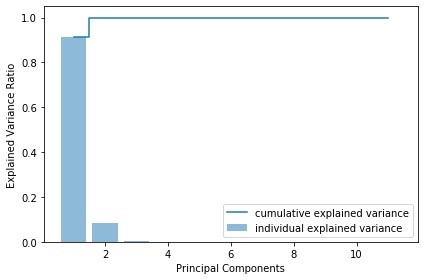

In [18]:
plot_variance(var_exp[:11], cum_var_exp[:11], save_as='Spambase/exp_var_plot')

In [19]:
cum_var_exp

array([0.91391701, 0.9978482 , 0.99990658, 0.99993738, 0.99994839,
       0.99995544, 0.99995993, 0.99996408, 0.99996774, 0.99997067,
       0.99997354, 0.99997582, 0.999978  , 0.99998003, 0.99998191,
       0.99998371, 0.99998525, 0.99998651, 0.99998765, 0.99998874,
       0.99998974, 0.9999905 , 0.99999121, 0.99999188, 0.99999251,
       0.99999309, 0.99999365, 0.99999418, 0.99999467, 0.99999507,
       0.99999546, 0.99999583, 0.99999618, 0.99999652, 0.99999684,
       0.99999715, 0.99999745, 0.99999775, 0.99999797, 0.99999817,
       0.99999837, 0.99999856, 0.99999874, 0.99999891, 0.99999906,
       0.99999919, 0.99999932, 0.99999944, 0.99999956, 0.99999967,
       0.99999977, 0.99999986, 0.99999992, 0.99999996, 0.99999999,
       1.        , 1.        ])

In [20]:
pca = PCA(n_components=2, copy=True, 
          whiten=False, svd_solver='auto', 
          tol=0.0, iterated_power='auto', 
          random_state=42)

In [21]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
X_proj_pca = pca.inverse_transform(X_train_pca)

# Calculate reconstruction error
mse_pca = ((X_train - X_proj_pca)**2).mean()
print(mse_pca)

14.104563388765131


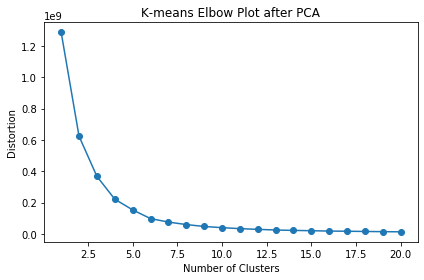

In [23]:
# Elbow around k=4
plot_elbow_distortions(max_clusters=20, X=X_train_pca, title='K-means Elbow Plot after PCA', 
                       save_as='Spambase/kmeans_elbow_plot_PCA')

In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [25]:
%%time
kmeans.fit(X_train_pca)

Wall time: 2.12 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

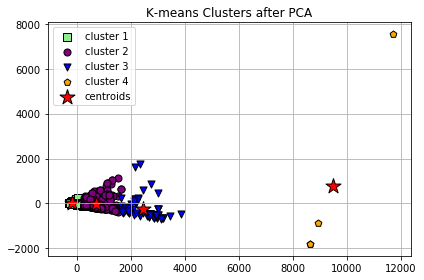

In [26]:
plot_kmeans(km=kmeans, X=X_train_pca, title='K-means Clusters after PCA', save_as='Spambase/kmeans_clusters_PCA')

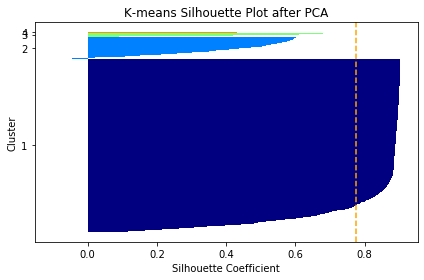

In [27]:
plot_silhouette(km=kmeans, X=X_train_pca, title='K-means Silhouette Plot after PCA', 
                save_as='Spambase/silhouette_plot_PCA')

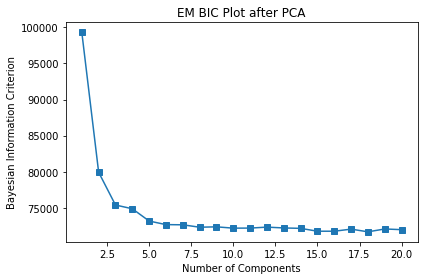

In [28]:
plot_elbow_bic(max_components=20, X=X_train_pca, title='EM BIC Plot after PCA', 
               save_as='Spambase/EM_BIC_plot_PCA')

In [29]:
gaussian_mix = GaussianMixture(n_components=6, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [30]:
%%time
gaussian_mix.fit(X_train_pca)

Wall time: 287 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

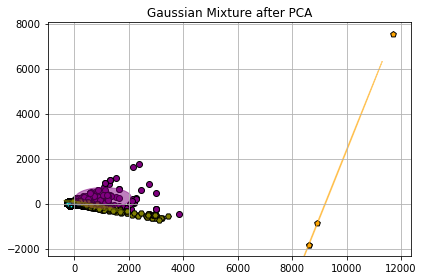

In [31]:
plot_gmm(gmm=gaussian_mix, X=X_train_pca, title='Gaussian Mixture after PCA', 
         save_as='Spambase/gmm_clusters_PCA')

### Independent Component Analysis

In [32]:
kurtosis_list = []
for i in range(1, 21):
    ica = FastICA(n_components=i, algorithm='parallel', 
                  max_iter=200, tol=0.0001,
                  random_state=42)
    X_train_ica = ica.fit_transform(X_train)
    df = pd.DataFrame(ica.components_)
    kurtosis_list.append(df.kurtosis(axis=1).mean())

In [33]:
np.array(kurtosis_list).argmax()

3

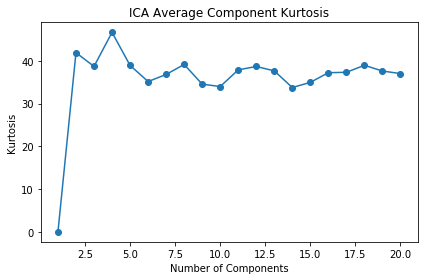

In [34]:
plot_kurtosis(max_components=20, kurtosis=kurtosis_list, title='ICA Average Component Kurtosis', 
              save_as='Spambase/kurtosis_ICA')

In [35]:
ica = FastICA(n_components=4, algorithm='parallel', 
                  max_iter=200, tol=0.0001,
                  random_state=42)

In [36]:
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

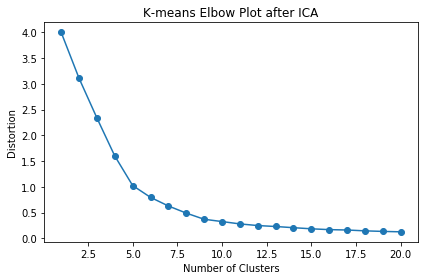

In [37]:
# Elbow around k=5
plot_elbow_distortions(max_clusters=20, X=X_train_ica, title='K-means Elbow Plot after ICA', 
                       save_as='Spambase/kmeans_elbow_plot_ICA')

In [38]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [39]:
%%time
kmeans.fit(X_train_ica)

Wall time: 1.82 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

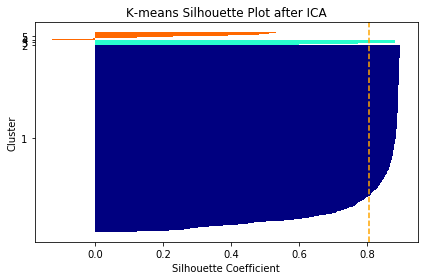

In [40]:
plot_silhouette(km=kmeans, X=X_train_ica, title='K-means Silhouette Plot after ICA', 
                save_as='Spambase/silhouette_plot_ICA')

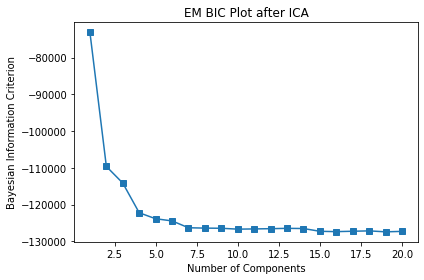

In [41]:
plot_elbow_bic(max_components=20, X=X_train_ica, title='EM BIC Plot after ICA', 
               save_as='Spambase/EM_BIC_plot_ICA')

In [42]:
gaussian_mix = GaussianMixture(n_components=7, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [43]:
%%time
gaussian_mix.fit(X_train_ica)

Wall time: 73.8 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### Random Projection (Gaussian)

In [44]:
mse_list = []
for i in range(1, X_train.shape[1]+1):
    for j in range(1, 21):
        temp_list = []
        grp = GaussianRandomProjection(n_components=i, 
                                       eps=0.1, 
                                       random_state=j)
        X_train_grp = grp.fit_transform(X_train)

        w = grp.components_
        p = pinv(w)
        X_proj_grp = ((p@w)@(X_train.T)).T
        
        # Calculate reconstruction error
        mse_grp = ((X_train - X_proj_grp)**2).mean()
        temp_list.append(mse_grp)
    mse_list.append(np.array(temp_list).mean())

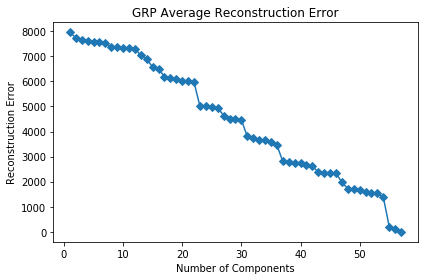

In [45]:
plot_recon_error(max_components=X_train.shape[1], error=mse_list, title='GRP Average Reconstruction Error', 
                 save_as='Spambase/GRP_recon_error')

In [46]:
roc_auc_list = []
for i in range(1, X_train.shape[1]+1):
    grp = GaussianRandomProjection(n_components=i, 
                                   eps=0.1, 
                                   random_state=42)
    X_train_grp = grp.fit_transform(X_train)

    pipe_mlp = Pipeline([('scl', StandardScaler()),
                         ('clf', MLPClassifier(max_iter=1000, 
                                               activation='relu', 
                                               solver='adam', 
                                               hidden_layer_sizes=(120,), 
                                               random_state=42))])
    pipe_mlp.fit(X_train_grp, y_train)
    y_pred = pipe_mlp.predict(X_train_grp)
    roc_auc_list.append(roc_auc_score(y_train, y_pred))

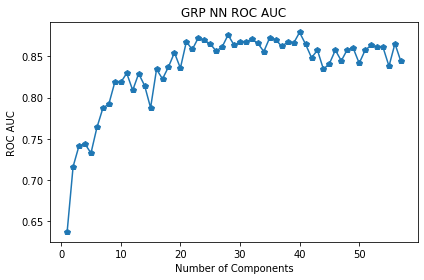

In [47]:
plot_auc_scores(max_components=X_train.shape[1], auc=roc_auc_list, title='GRP NN ROC AUC', save_as='Spambase/GRP_NN_AUC')

In [48]:
grp = GaussianRandomProjection(n_components=23, 
                               eps=0.1, 
                               random_state=42)

In [49]:
X_train_grp = grp.fit_transform(X_train)
X_test_grp = grp.transform(X_test)

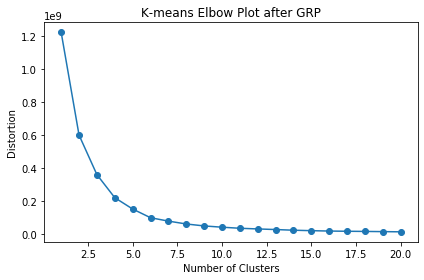

In [50]:
# Elbow around k=4
plot_elbow_distortions(max_clusters=20, X=X_train_grp, title='K-means Elbow Plot after GRP', 
                       save_as='Spambase/kmeans_elbow_plot_GRP')

In [51]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [52]:
%%time
kmeans.fit(X_train_grp)

Wall time: 1.95 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

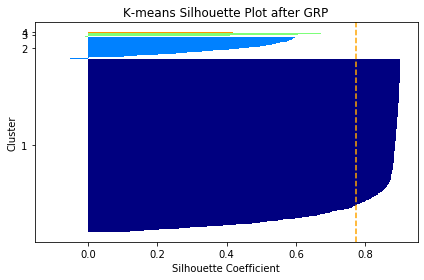

In [53]:
plot_silhouette(km=kmeans, X=X_train_grp, title='K-means Silhouette Plot after GRP', 
                save_as='Spambase/silhouette_plot_GRP')

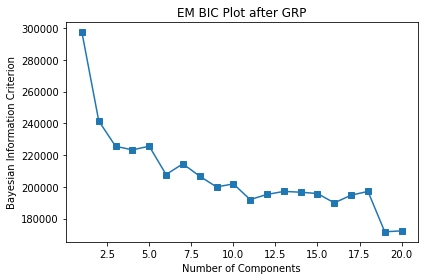

In [54]:
plot_elbow_bic(max_components=20, X=X_train_grp, title='EM BIC Plot after GRP', 
               save_as='Spambase/EM_BIC_plot_GRP')

In [55]:
gaussian_mix = GaussianMixture(n_components=6, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [56]:
%%time
gaussian_mix.fit(X_train_grp)

Wall time: 275 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### Linear Discriminant Analysis

In [57]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(0, 2):
    mean_vecs.append(np.mean(X_train[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label]))

MV 0: [7.2713e-02 2.2426e-01 2.0294e-01 7.5758e-04 1.7660e-01 4.3366e-02
 9.4744e-03 3.7410e-02 3.6638e-02 1.6943e-01 2.3513e-02 5.2964e-01
 6.3509e-02 4.4323e-02 6.9650e-03 8.1681e-02 4.7225e-02 9.3338e-02
 1.2705e+00 7.4621e-03 4.3120e-01 4.2282e-02 6.7330e-03 2.0554e-02
 8.7564e-01 3.9777e-01 1.2640e+00 1.9170e-01 1.4723e-01 1.5949e-01
 9.6951e-02 6.8750e-02 1.4578e-01 6.9323e-02 1.6886e-01 1.3609e-01
 2.0598e-01 1.7538e-02 1.2699e-01 7.4223e-02 7.3991e-02 2.0925e-01
 7.1690e-02 1.4154e-01 4.4333e-01 2.8690e-01 7.4574e-03 5.1667e-02
 4.7201e-02 1.6217e-01 2.2173e-02 1.1895e-01 1.2290e-02 2.3759e-02
 2.4303e+00 1.8455e+01 1.5348e+02]

MV 1: [1.4964e-01 1.6981e-01 4.0490e-01 1.5066e-01 5.0906e-01 1.7217e-01
 2.6456e-01 2.1129e-01 1.6853e-01 3.4435e-01 1.1596e-01 5.6162e-01
 1.3868e-01 8.6009e-02 1.1333e-01 5.4031e-01 2.8474e-01 3.0801e-01
 2.2773e+00 1.8883e-01 1.3905e+00 2.4297e-01 2.5076e-01 2.2046e-01
 1.8498e-02 1.0897e-02 6.8759e-04 2.1704e-02 8.3707e-04 3.3931e-03
 1.3154e-03 7.

In [58]:
d = X.shape[1] # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.cov(X_train[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 57x57


In [59]:
mean_overall = np.mean(X_train, axis=0)
d = 57  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 57x57


In [60]:
eigen_vals, eigen_vecs = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))

In [61]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
# print('Eigenvalues in descending order:\n')
# for eigen_val in eigen_pairs:
#     print(eigen_val[0])

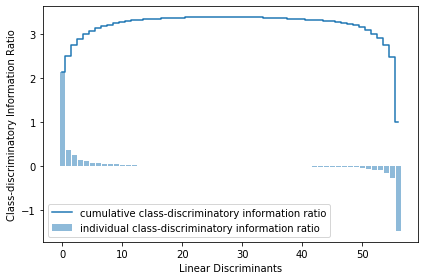

In [62]:
plot_discriminability(eigen_vals, save_as='Spambase/LDA_discriminability')

In [63]:
lda = LinearDiscriminantAnalysis(n_components=1, 
                                 solver='svd', 
                                 store_covariance=False, 
                                 tol=0.0001)

In [64]:
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

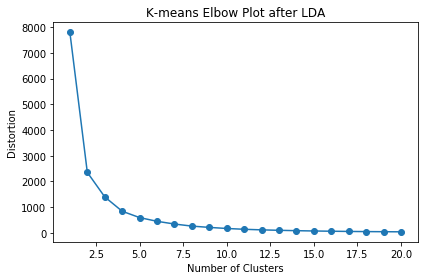

In [65]:
# Elbow around k=3
plot_elbow_distortions(max_clusters=20, X=X_train_lda, title='K-means Elbow Plot after LDA', 
                       save_as='Spambase/kmeans_elbow_plot_LDA')

In [66]:
kmeans = KMeans(n_clusters=3, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [67]:
%%time
kmeans.fit(X_train_lda)

Wall time: 1.89 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

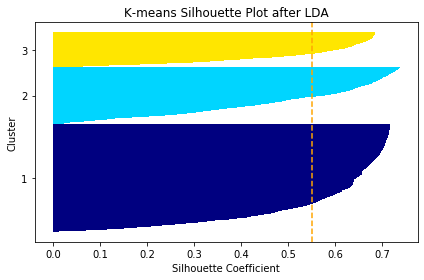

In [68]:
plot_silhouette(km=kmeans, X=X_train_lda, title='K-means Silhouette Plot after LDA', 
                save_as='Spambase/silhouette_plot_LDA')

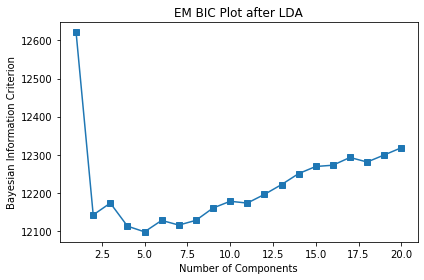

In [69]:
plot_elbow_bic(max_components=20, X=X_train_lda, title='EM BIC Plot after LDA', 
               save_as='Spambase/EM_BIC_plot_LDA')

In [70]:
gaussian_mix = GaussianMixture(n_components=5, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [71]:
%%time
gaussian_mix.fit(X_train_lda)

Wall time: 29.9 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### Random Forest Feature Selection

In [72]:
feat_labels = spambase_df.columns[:-1]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) 51                             0.113910
 2) 52                             0.096275
 3) 6                              0.083639
 4) 15                             0.065957
 5) 54                             0.065574
 6) 55                             0.055866
 7) 20                             0.055577
 8) 56                             0.044894
 9) 24                             0.042319
10) 23                             0.033763
11) 4                              0.032634
12) 18                             0.029829
13) 22                             0.024228
14) 26                             0.021918
15) 45                             0.016359
16) 25                             0.016221
17) 7                              0.013768
18) 36                             0.013365
19) 49                             0.012660
20) 2                              0.012595
21) 11                             0.012543
22) 16                             0.012153
23) 44                          

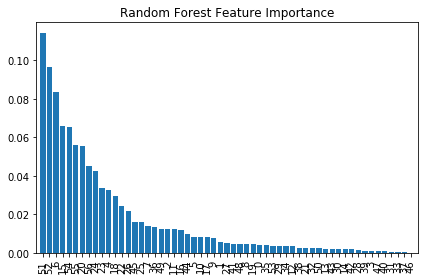

In [73]:
plot_feature_importance(X=X_train, importances=importances, indices=indices, save_as='Spambase/RF_feature_importance')

In [74]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.012, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 22


In [75]:
importances = list(importances)
importances.sort(reverse=True)
sum(importances[:22])

0.8760467476194793

In [76]:
X_train_rf = X_train[:, indices[:22]]

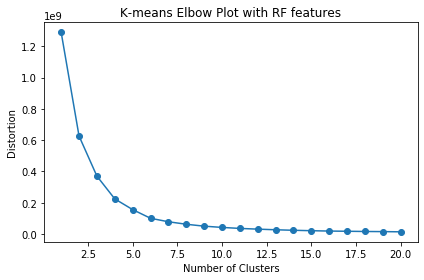

In [77]:
# Elbow around k=3
plot_elbow_distortions(max_clusters=20, X=X_train_rf, title='K-means Elbow Plot with RF features', 
                       save_as='Spambase/kmeans_elbow_plot_RF')

In [78]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [79]:
%%time
kmeans.fit(X_train_rf)

Wall time: 2.16 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

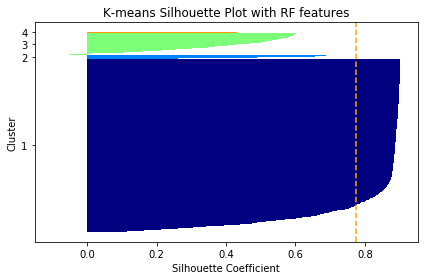

In [80]:
plot_silhouette(km=kmeans, X=X_train_rf, title='K-means Silhouette Plot with RF features', 
                save_as='Spambase/silhouette_plot_RF')

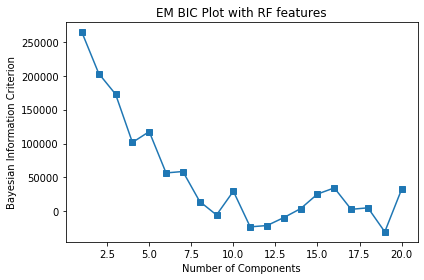

In [81]:
plot_elbow_bic(max_components=20, X=X_train_rf, title='EM BIC Plot with RF features', 
               save_as='Spambase/EM_BIC_plot_RF')